# Assignment 1

In a world where isolation is an increasingly prevalent issue, this analysis aims to investigate how engagement in arts and cultural activities is associated with social connectedness in Singapore. Social connectedness can be defined as the experience of belonging to a social relationship or network (SciDirect, 3). By investigating this issue from a macro, micro, and policy perspective, this analysis explores how engagement in arts and cultural activities relates to social connectedness, as well as where improvements in access to such opportunities may be considered.

To begin, 5 datasets are used to complete this analysis. 

1. **Social Values Survey**: Initially designed to examine Singaporean's desire to build social capital, the survey does not directly measure social isolation, but the ```outcome_connection``` variable captures respondents’ perceived sense of belonging and connection to Singapore, which reflects an important dimension of social connectedness that is inversely related to experiences of social isolation. There are also key variables captured in this dataset, such as the social activities that the respondent partakes in, as well as whether or not they are involved in arts/culture activities.

2. **Resident Population by Planning Area**: Using this dataset, the population of youths in each area can be determined. This analysis focuses on youths aged 15–24 because this life stage is characterised by identity formation, expanding social networks, and heightened sensitivity to opportunities for social participation. Engagement in arts and cultural activities during this period can serve as a key mechanism for peer interaction, self-expression, and community belonging.

3. **Community Clubs**: This dataset identifies where the community clubs in Singapore are located. Many arts and culture events such as art classes and performances are held in community clubs, which can provide increased opportunities to the arts for youths. In addition, many community clubs host events which are either heavily subsidised or free, which will make many of the activities hosted accessible and affordable to much of the population.

4. **Theatre**: This dataset provides the locations of theatres in Singapore. This allows for us to investigate where the areas that are specifically designed for the arts are located, which allows for youths to partake in arts and culture activities.

5. **Planning Area Boundaries**: This dataset allows for the geographical planning areas of Singapore to be identified, thus allowing for the plotting of the various planning areas.

## Libraries

In [25]:
#!pip install matplotlib
#!pip install geopandas

In [26]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
from matplotlib.path import Path

In [27]:
COLORS = {
    "arts": "#D55E00",        # vermillion (arts / people)
    "infrastructure": "#0072B2",  # blue (community clubs)
    "neutral": "#999999",     # grey (baseline)
    "light": "#F0F0F0"        # background
}

## Macro Plot

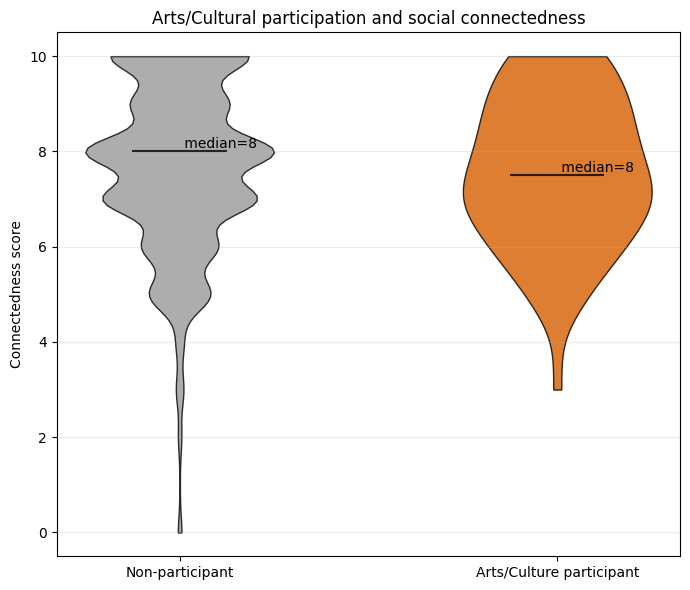

In [28]:
svs = pd.read_csv("data/Social Values Survey data.csv")
svs.columns = [c.strip().lower().replace(" ", "_") for c in svs.columns]

# keep required fields
# here social connectedness is defined by the 'outcome_connection' column, where it is the survey taker's own belief of how socially connected they think they are.
df = svs[["social_involve_2", "outcome_connection"]].dropna().copy()

# arts participation: yes/no
df["arts_participant"] = (df["social_involve_2"].astype(str).str.strip().str.lower() == "yes")

# change to numeric to be able to plot it out
def to_numeric_score(x):
    s = str(x)
    # grab first integer in the string
    import re
    m = re.search(r"\d+", s)
    return float(m.group()) if m else np.nan

df["connection_score"] = df["outcome_connection"].apply(to_numeric_score)
df = df.dropna(subset=["connection_score"])

# split into two groups
a = df.loc[df["arts_participant"], "connection_score"].values
b = df.loc[~df["arts_participant"], "connection_score"].values

# start plot
fig, ax = plt.subplots(figsize=(7,6))

parts = ax.violinplot([b, a], showmeans=False, showmedians=True, showextrema=False)
for i, body in enumerate(ax.collections):
    if i == 0:  # non-participants
        body.set_facecolor(COLORS["neutral"])
    else:       # arts participants
        body.set_facecolor(COLORS["arts"])
    body.set_edgecolor("black")
    body.set_alpha(0.8)
ax.set_xticks([1, 2])
ax.set_xticklabels(["Non-participant", "Arts/Culture participant"])

ax.set_ylabel("Connectedness score")
ax.set_title("Arts/Cultural participation and social connectedness")
ax.grid(True, axis="y", alpha=0.25)

# Add clear median labels
med_non = np.median(b) if len(b) else np.nan
med_art = np.median(a) if len(a) else np.nan
ax.text(1, med_non, f" median={med_non:.0f}", va="bottom")
ax.text(2, med_art, f" median={med_art:.0f}", va="bottom")

plt.tight_layout()
plt.show()


Firstly, a general comparison of respondents' social connectedness is done. These respondents are categorised into two groups: non-participants and arts/culture participant. The aim of this plot is to examine whether participation in arts/culture activities may help in combating the issue of social isolation in Singapore.

In this plot, we see that the non-participants have a longer lower tail while arts/culture participants have a shorter lower tail, with many values congregating at the upper end of the connectedness score. This indicates that the participation in arts/culture activities could be a factor to alleviate the problem of social isolation. Given that social isolation is a risk factor for poor mental health (APA, 1), this plot suggests that participation in arts/culture activites may help in combating the issue of social isolation in Singapore.

## Micro Plot

C:\Users\206910279\AppData\Local\Temp\ipykernel_59456\2206779834.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  [float(prop.loc[False, k]), float(prop.loc[True, k])],


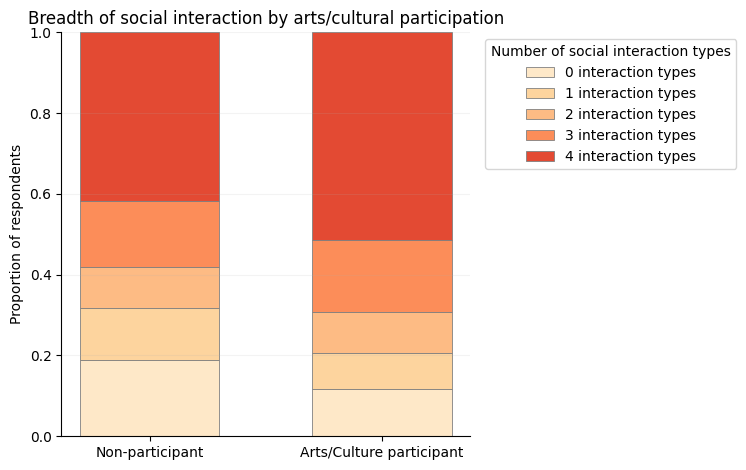

In [31]:
# select interaction variables
df = svs[[
    "social_involve_2",
    "sinteract_meal",
    "sinteract_invitedfriend",
    "sinteract_beeninvited",
    "sinteract_participated"
]].dropna().copy()

# arts/culture participant?
df["arts_participant"] = (
    df["social_involve_2"].astype(str).str.strip().str.lower().eq("yes")
)

# change to binary
interact_cols = [
    "sinteract_meal", # meals with friends
    "sinteract_invitedfriend", # invite friend to home
    "sinteract_beeninvited", # invited to friend house
    "sinteract_participated" # participate in social activity
]
for c in interact_cols:
    df[c] = df[c].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})

df = df.dropna(subset=interact_cols)

# label with number from 0-4
df["interaction_breadth"] = df[interact_cols].sum(axis=1).astype(int)

# proportion
prop = (
    df.groupby(["arts_participant", "interaction_breadth"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
      .unstack(fill_value=0)
)

# check values
for k in range(5):
    if k not in prop.columns:
        prop[k] = 0.0
prop = prop[[0, 1, 2, 3, 4]]

if True not in prop.index:
    prop.loc[True] = 0.0
if False not in prop.index:
    prop.loc[False] = 0.0

# plot
labels = ["Non-participant", "Arts/Culture participant"]
x = np.array([0, 1], dtype=float)
bottom = np.zeros(2, dtype=float)

fig, ax = plt.subplots(figsize=(7.6, 4.8))

breadth_colors = {
    0: "#fee8c8",  # very light (isolated)
    1: "#fdd49e",
    2: "#fdbb84",
    3: "#fc8d59",
    4: "#e34a33"   # darkest (high social breadth)
}

for k in prop.columns:
    vals = np.array(
        [float(prop.loc[False, k]), float(prop.loc[True, k])],
        dtype=float
    )

    ax.bar(
        x,
        vals,
        bottom=bottom,
        width=0.6,
        color=breadth_colors[k],
        edgecolor = "gray",
        linewidth=0.6,
        label=f"{k} interaction types"
    )

    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.set_ylabel("Proportion of respondents")
ax.set_title("Breadth of social interaction by arts/cultural participation")

ax.grid(axis="y", alpha=0.15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(
    title="Number of social interaction types",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=True
)

plt.tight_layout()
plt.show()


Next, the micro plot zooms in to investigate the types of social interactions that each group partakes in.

Here, interaction types are defined as common interpersonal activities captured by the Social Values Survey: having meals together with others, inviting friends to one's home, being invited to someone else's home, and participating in social activities, as defined in the survey. From this, the number of interaction types that the respondent partakes in is counted, and plotted into the diagram. The distribution indicates that arts and cultural participants, in fact, have a larger proportion of respondents who partake in a broader range of interaction types. The proportion of non-participants who take part in 0 interaction types are notably higher than those who partake in arts/culture activities. This pattern suggests that those who take part in arts/culture activities have broader social embeddedness at the individual level. As broader social embeddedness is a known protective factor against social isolation (Scispace, 2), this suggests that arts/culture participation could lead to improved mental health outcomes.

## Policy Plot

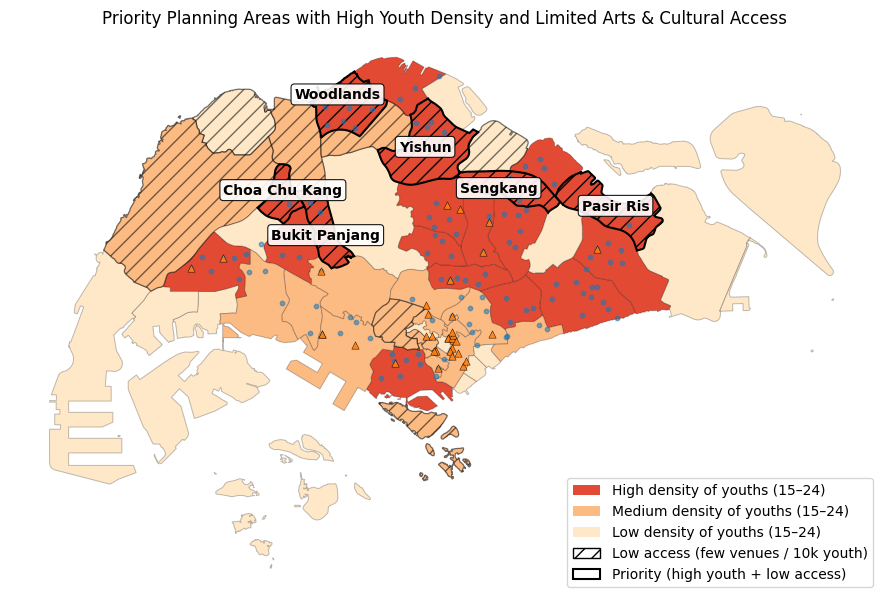

In [32]:
# youths in each area
pop = pd.read_csv("data/ResidentPopulationbyPlanningAreaSubzoneofResidenceAgeGroupandSexCensusofPopulation2020.csv")
pop.columns = [c.strip().lower().replace(" ", "_") for c in pop.columns]

area_totals = pop[pop["number"].astype(str).str.endswith(" - Total")].copy()
area_totals = area_totals[area_totals["number"] != "Total"].copy()

area_totals["planning_area"] = (
    area_totals["number"].astype(str)
    .str.replace(r"\s*-\s*Total$", "", regex=True)
    .str.upper()
    .str.strip()
)

area_totals["youth_15_24"] = (
    pd.to_numeric(area_totals["total_15_19"], errors="coerce") +
    pd.to_numeric(area_totals["total_20_24"], errors="coerce")
).fillna(0)

youth_map = area_totals.set_index("planning_area")["youth_15_24"].to_dict()

# get each area's polygon
with open("data/MasterPlan2019PlanningAreaBoundaryNoSea.geojson", "r") as f:
    pa_gj = json.load(f)

area_polys = {}
centroids = {}

for feat in pa_gj["features"]:
    area = str(feat["properties"].get("PLN_AREA_N", "")).upper().strip()
    geom = feat["geometry"]
    rings = []

    if geom["type"] == "Polygon":
        rings = [np.array(geom["coordinates"][0], dtype=float)]
    elif geom["type"] == "MultiPolygon":
        rings = [np.array(poly[0], dtype=float) for poly in geom["coordinates"]]
    if not rings:
        continue
    area_polys[area] = rings
    largest = max(rings, key=lambda r: r.shape[0])
    centroids[area] = (largest[:, 0].mean(), largest[:, 1].mean())

# cc and theatre
with open("data/CommunityClubs.geojson", "r") as f:
    cc_gj = json.load(f)
cc_xy = np.array([feat["geometry"]["coordinates"][:2] for feat in cc_gj["features"]], dtype=float)

with open("data/Theatre.geojson", "r") as f:
    th_gj = json.load(f)
th_xy = np.array([feat["geometry"]["coordinates"][:2] for feat in th_gj["features"]], dtype=float)

# points in each area --> density
def count_points_in_area(rings, points_xy):
    if points_xy.size == 0:
        return 0
    inside_any = np.zeros(points_xy.shape[0], dtype=bool)
    for ring in rings:
        inside_any |= Path(ring).contains_points(points_xy)
    return int(inside_any.sum())

rows = []
for area, rings in area_polys.items():
    youth = float(youth_map.get(area, 0.0))
    cc_count = count_points_in_area(rings, cc_xy)
    th_count = count_points_in_area(rings, th_xy)
    venues_total = cc_count + th_count
    venues_per_10k = (venues_total / youth * 10000) if youth > 0 else np.nan
    rows.append((area, youth, venues_per_10k, venues_total, cc_count, th_count))

df = pd.DataFrame(
    rows,
    columns=["planning_area", "youth_15_24", "venues_per_10k_youth", "venues_total", "cc_count", "theatre_count"]
)

# mapping
df_plot = df.copy()
df_plot = df_plot[df_plot["youth_15_24"].notna()].copy()

# get the quantiles: so that easily plottable
df_plot["youth_bin"] = pd.qcut(df_plot["youth_15_24"], q=3, labels=[0, 1, 2], duplicates="drop")
df_plot["access_bin"] = pd.qcut(df_plot["venues_per_10k_youth"], q=3, labels=[0, 1, 2], duplicates="drop")

youth_bin_map = df_plot.set_index("planning_area")["youth_bin"].to_dict()
access_bin_map = df_plot.set_index("planning_area")["access_bin"].to_dict()

# color
youth_colors = {
    0: "#fee8c8",  # low
    1: "#fdbb84",  # medium
    2: "#e34a33",  # high
}

# need to label: low access, high pop
priority_bi = df_plot[(df_plot["youth_bin"] == 2) & (df_plot["access_bin"] == 0)]
priority_areas_bi = priority_bi["planning_area"].tolist()
priority_set = set(priority_areas_bi)

# plot
fig, ax = plt.subplots(figsize=(9, 9))

for area, rings in area_polys.items():
    yb = youth_bin_map.get(area, 0)
    ab = access_bin_map.get(area, 2)
    fill = youth_colors.get(int(yb), "#eeeeee")

    for ring in rings:
        poly = Polygon(ring, closed=True)
        poly.set_facecolor(fill)
        poly.set_edgecolor((0, 0, 0, 0.25))
        poly.set_linewidth(0.7)
        poly.set_zorder(1)

        # low access
        if pd.notna(ab) and int(ab) == 0:
            poly.set_hatch("//")
            poly.set_edgecolor((0, 0, 0, 0.55))
            poly.set_linewidth(0.9)

        # priority need to highlight
        if area in priority_set:
            poly.set_edgecolor("black")
            poly.set_linewidth(1.5)
            poly.set_zorder(2)

        ax.add_patch(poly)

# points
ax.scatter(cc_xy[:, 0], cc_xy[:, 1], s=10, color="#1f77b4", alpha=0.55, label="Community Clubs", zorder=3)
ax.scatter(th_xy[:, 0], th_xy[:, 1], s=28, marker="^", color="#ff7f0e", edgecolor="black", linewidth=0.35, alpha=0.9, label="Theatres / Arts venues", zorder=4)

# label for the priority area
for area in priority_set:
    if area in centroids:
        cx, cy = centroids[area]
        ax.text(
            cx, cy,
            area.title(),
            fontsize=10,
            weight="bold",
            ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", lw=0.8, alpha=0.9),
            zorder=5
        )

ax.set_aspect("equal")
ax.axis("off")

ax.set_title(
    "Priority Planning Areas with High Youth Density and Limited Arts & Cultural Access",
    fontsize=12
)

# add a legend
legend_items = [
    mpatches.Patch(facecolor=youth_colors[2], edgecolor="none", label="High density of youths (15–24)"),
    mpatches.Patch(facecolor=youth_colors[1], edgecolor="none", label="Medium density of youths (15–24)"),
    mpatches.Patch(facecolor=youth_colors[0], edgecolor="none", label="Low density of youths (15–24)"),
    mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Low access (few venues / 10k youth)"),
    mpatches.Patch(facecolor="none", edgecolor="black", linewidth=1.5, label="Priority (high youth + low access)")
]
ax.legend(handles=legend_items, loc="lower right", frameon=True)

plt.tight_layout()
plt.show()


Lastly, the policy plot identifies youth-dense planning areas where access to arts and cultural spaces is relatively limited, highlighting locations where targeted cultural interventions may have the greatest relevance.

Youth density is represented through the intensity of the fill colour, while areas with low access are indicated through hatching. These areas highlight potential spatial mismatches between where youths reside and where opportunities for arts-based social engagement are most readily available. While increased access to arts/culture spaces alone does not increase youths' engagement with the arts, it would give them the greater opportunity to participate. In addition to expanding the availability of arts and cultural spaces, active outreach and targeted engagement initiatives remain essential to ensure that youths are aware of, feel welcomed into, and are able to meaningfully participate in such opportunities.

## Citations

1. https://www.apa.org/monitor/2019/05/ce-corner-isolation
2. https://scispace.com/pdf/social-isolation-and-loneliness-5buj43e1by.pdf
3. https://www.sciencedirect.com/topics/psychology/social-connectedness

## Data

1. https://data.gov.sg/datasets/d_4765db0e87b9c86336792efe8a1f7a66/view
2. https://data.gov.sg/datasets/d_05fffefe9045d234eb140d7db0acdeb9/view
3. https://data.gov.sg/datasets/d_0ef47f84a0776b27010b242038ea2c6b/view
4. https://data.gov.sg/datasets/d_f706de1427279e61fe41e89e24d440fa/view
5. https://data.gov.sg/datasets/d_39620e0a12a31733842dcb6759b51a85/view